<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/02_pytorch_classification_exercises_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn

## 1. Make classification data

In [ ]:
# Create moons
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

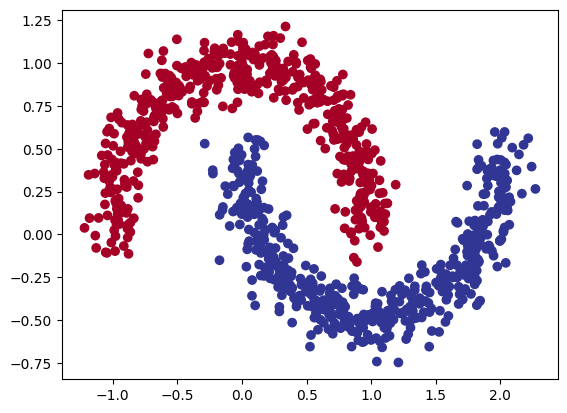

In [ ]:
# Visualize data
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5]

tensor([[-0.0515,  0.4442],
        [ 1.0320, -0.4197],
        [ 0.8679, -0.2548],
        [ 0.2889, -0.4487],
        [-0.8334,  0.5351]])

In [ ]:
y[:5]

tensor([1., 1., 1., 1., 0.])

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Check sizes
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
# Build a classification model
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=5):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [ ]:
model_0 = MoonModel(
    input_features=2,
    output_features=1,
    hidden_units=10).to(device)

In [ ]:
model_0

MoonModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

## 3. Setup Loss function and Optimizer

In [ ]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# Define accuracy function
def acc_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

## 4. Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Building training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_prob)

    # Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient descent
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred_prob = torch.sigmoid(test_logits)
        test_pred = torch.round(test_pred_prob)

        # Calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68779, Acc: 50.00% | Test loss: 0.68809, Test acc: 50.00%
Epoch: 100 | Loss: 0.46784, Acc: 81.88% | Test loss: 0.48087, Test acc: 79.50%
Epoch: 200 | Loss: 0.24297, Acc: 89.00% | Test loss: 0.24137, Test acc: 90.50%
Epoch: 300 | Loss: 0.18309, Acc: 92.38% | Test loss: 0.17391, Test acc: 92.50%
Epoch: 400 | Loss: 0.10894, Acc: 96.25% | Test loss: 0.09591, Test acc: 97.50%
Epoch: 500 | Loss: 0.04955, Acc: 99.00% | Test loss: 0.04198, Test acc: 99.50%
Epoch: 600 | Loss: 0.02651, Acc: 99.75% | Test loss: 0.02179, Test acc: 100.00%
Epoch: 700 | Loss: 0.01761, Acc: 99.88% | Test loss: 0.01388, Test acc: 100.00%
Epoch: 800 | Loss: 0.01301, Acc: 99.88% | Test loss: 0.00990, Test acc: 100.00%
Epoch: 900 | Loss: 0.01026, Acc: 99.88% | Test loss: 0.00757, Test acc: 100.00%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


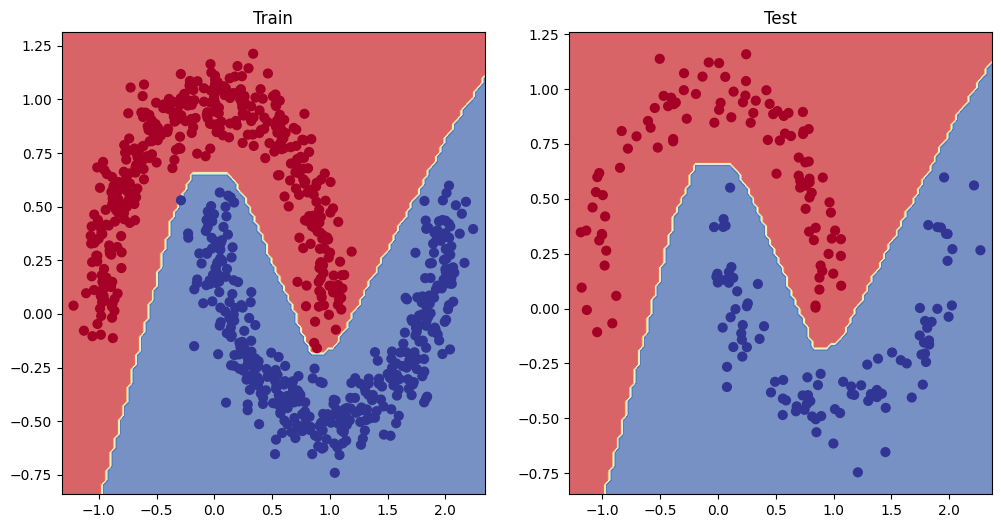

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)